In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.special import expit
import matplotlib.pyplot as plt

data_path = "Z:\\f.afsari\\4-DUET\\database\\Tx_data"

original_files_path = Path(data_path) / "Excel_files" / "Original files"
obtained_files_path = Path(data_path) / "Excel_files" / "Obtained files"



### Relabling Process:

In [72]:
# Load the time series data and relabel SP#, assigning it to Patient_ID
original_files_path = Path(data_path) / "Excel_files" / "Original files"

time_seris_df_dead = pd.read_excel(Path(data_path) / "Excel_files" / "Original files" / "TimeSeriesData-deID-dead - Copy.xlsx", 
                                   sheet_name='DDRT', usecols=['SP#', 'Bx Reason', 'Time Post-Tx', '3mo SCr',	'6mo SCr',	'1yr SCr',
                                                               '2yr SCr',	'3yr SCr',	'4yr SCr',	'5yr SCr',	'6yr SCr',	'7yr SCr',	'Latest SCr', 
                                                               'Gender',	'Race',	'Age'
                                                               ])

time_seris_df_donor = pd.read_excel(Path(data_path) / "Excel_files" / "Original files" / "TimeSeriesData-deID-dead - Copy.xlsx", 
                                    sheet_name='LRT', usecols=['SP#', 'Date',	'Bx Reason', 'Time Post-Tx', '3mo SCr',	'6mo SCr',	'1yr SCr',
                                                               '2yr SCr',	'3yr SCr',	'4yr SCr',	'5yr SCr',	'6yr SCr',	'7yr SCr',	'Latest SCr', 
                                                               'Gender',	'Race',	'DOB'
                                                               ])

s = 55761
e = s + len(time_seris_df_dead)
patient_ids_dead = [i for i in range(s, e)]
print(len(patient_ids_dead), len(time_seris_df_dead))
time_seris_df_dead['Patient_ID'] = patient_ids_dead

s = e + 1
e = s + len(time_seris_df_donor)
patient_ids_donor = [i for i in range(s, e)]
print(len(patient_ids_donor), len(time_seris_df_donor))

# Calculate age
time_seris_df_donor['Age'] = time_seris_df_donor['Date'].dt.year - time_seris_df_donor['DOB'].dt.year
    # - ((time_seris_df_donor['Date'].dt.month, time_seris_df_donor['Date'].dt.day) < (time_seris_df_donor['DOB'].dt.month, time_seris_df_donor['DOB'].dt.day))
time_seris_df_donor.drop(columns=['Date', 'DOB'], inplace=True)

time_seris_df_donor['Patient_ID'] = patient_ids_donor

with pd.ExcelWriter(Path(data_path) / "Excel_files" / "Original files" / "TimeSeriesData-deID_fatemeh.xlsx") as writer:
    time_seris_df_dead.to_excel(writer, sheet_name="DDRT", index=False)
    time_seris_df_donor.to_excel(writer, sheet_name="LRT", index=False)


493 493
55 55


In [ ]:
# Load kidney database and add Patient_ID
kidney_database = pd.read_excel(Path(data_path) / "Excel_files" / "Original files" / "KidneyDatabase_edit_relabled.xlsx", sheet_name=None)

s = 56310

with pd.ExcelWriter(Path(data_path) / "Excel_files" / "Original files" / "KidneyDatabase_edit_relabled_fatemeh.xlsx") as writer:
    for shet_name, kidney_sheet in kidney_database.items(): 
        
        non_exist_ids = kidney_sheet[pd.isna(kidney_sheet['Patient_ID'])].index

        # print(non_exist_ids)
        if len(non_exist_ids) > 0:
            patient_ids = [s + i for i in range(len(non_exist_ids))]
            kidney_sheet.loc[pd.isna(kidney_sheet['Patient_ID']), 'Patient_ID'] = patient_ids

        
        s = s + len(non_exist_ids)
        # print(kidney_sheet.head())

        kidney_sheet.to_excel(writer, sheet_name=shet_name, index=False)
        



In [91]:
# Load kidney database and concat two column to create the SP#
kidney_database = pd.read_excel(Path(data_path) / "Excel_files" / "Original files" / "KidneyDatabase_edit_relabled.xlsx", sheet_name=None)

kidney_df = pd.DataFrame()

with pd.ExcelWriter(Path(data_path) / "Excel_files" / "Original files" / "KidneyDatabase_edit_fatemeh.xlsx") as writer:
    for shet_name, kidney_sheet in kidney_database.items(): 
        # print(sheet_name)
        if '2016' in shet_name or '2017' in shet_name:
            kidney_sheet = pd.read_excel(Path(data_path) / 'Excel_files' / 'Original files' / 'KidneyDatabase_edit.xlsx', sheet_name=shet_name, header=1)        
            # print(kidney_sheet.columns)
            kidney_sheet['SP#'] = kidney_sheet['Unnamed: 0'].astype(str) + kidney_sheet['SP#'].astype(str) 
        else:
            # print(kidney_sheet.columns)
            kidney_sheet['SP#'] = kidney_sheet['SP#'].astype(str) + kidney_sheet['Unnamed: 2'].astype(str)
        
        kidney_sheet = pd.merge(kidney_sheet, time_seris_df_dead[['SP#', 'Patient_ID']], on='SP#', how='left')
        kidney_sheet = pd.merge(kidney_sheet, time_seris_df_donor[['SP#', 'Patient_ID']], on='SP#', how='left')       
        
        kidney_df = pd.concat([kidney_df, kidney_sheet], ignore_index=True)
        kidney_sheet.to_excel(writer, sheet_name=shet_name, index=False)
        

kidney_df.to_excel(Path(data_path) / 'Excel_files' / 'Original files' / 'KidneyDatabase_edit_all-in-one-sheet.xlsx', index=False)



In [ ]:
# Load the kidney data and relabel SP#, matching with time series Patient_IDs
# Find where the two columns match
time_seris_df_donor['SP#'] = time_seris_df_donor['SP#'].reset_index(drop=True)
kidney_sheet['SP#'] = kidney_sheet['SP#'].reset_index(drop=True)

matching_rows = time_seris_df_donor[time_seris_df_donor['SP#'].isin(kidney_sheet['SP#'])].index

# Convert to list if needed
matching_indices = matching_rows.tolist()

print(matching_indices)

time_seris_df_donor.iloc[matching_indices]


In [ ]:
matching_rows2 = kidney_sheet[kidney_sheet['SP#'].isin(time_seris_df_donor['SP#'])].index

# Convert to list if needed
matching_indices2 = matching_rows2.tolist()
print(matching_indices2)
kidney_sheet.iloc[matching_indices2]


### Starting the selection process

In [2]:
def calculate_egfr(creatinine, age, gender, race):
    """
    Calculate eGFR using the CKD-EPI equation.

    Parameters:
    creatinine (float): Serum creatinine level in mg/dL.
    age (int): Age in years.
    gender (str): 'male' or 'female'.
    race (str): 'black' or 'non-black'.

    Returns:
    float: Estimated Glomerular Filtration Rate (eGFR) in mL/min/1.73 m².
    """    
    
    # Calculate eGFR based on CDK-EDP Creatinine Equation (2021)
    '''\text{eGFR} = 142\times
                    min(\text{standardized} S_{cr}/K, 1)^\alpha \times
                    max(\text{standardized} S_{cr}/K, 1)^{-1.200} \times
                    0.9938^{\text{Age}} \times
                    1.012 [\text{if female}]$    '''
    
    gender = gender.lower()
    if gender == 'male':
        k = 0.9
        a = -0.302
        factor_gender = 1.0
        
    elif gender == 'female':
        k = 0.7
        a = -0.241
        factor_gender = 1.012
    else:   # missing gender
        k = 0.9
        a = -0.302
        factor_gender = 1.0
        
    if race == 'black':
        factor_race = 1.159
    else:
        factor_race = 1.0
    
    creatinine_adj = creatinine / k    
    min_creatinine_adj = min(creatinine_adj, 1)
    max_creatinine_adj = max(creatinine_adj, 1)
    b = -1.200
    
    egfr = 142 * (min_creatinine_adj ** a) * (max_creatinine_adj ** b) * (0.9938 ** age) * factor_gender * factor_race
        
    return egfr


In [3]:
calculate_egfr(0.97, 62, 'female', 'non-black')


66.06903341731214

In [ ]:
# Load the SCr data for each sheet

sheet_name = 'LRT'  # 'DDRT' or 'LRT'  

# Load the data
SCr_data = pd.read_excel(obtained_files_path / "SCr_long_data.xlsx", usecols=['Patient_ID', 'Age', 'Gender', 'SCr', 'Days', 'SP'], sheet_name=sheet_name)
SCr_data.rename(columns={'SP': 'SP#'}, inplace=True)

print(len(SCr_data))

# Drop NaN rows
# SCr_data = SCr_data.dropna()
SCr_data = SCr_data.dropna(subset=['SCr'])

# Optionally, reset the index of the original DataFrame after dropping rows
SCr_data.reset_index(drop=True, inplace=True)

# Print the number of unique Patient_IDs remaining in the original DataFrame
Patient_IDs = SCr_data['Patient_ID'].unique()
print(len(Patient_IDs), len(SCr_data))

SCr_data.head(n=5)


In [ ]:
# Calculate eGFR
patient_ids = SCr_data['Patient_ID'].values.tolist()
Days = SCr_data['Days'].values.tolist()
SPs = SCr_data['SP#'].values.tolist()
eGFR = []

for patient_id in Patient_IDs:
    patient_data = SCr_data[SCr_data['Patient_ID'] == patient_id]
    race = 'non-black'
    for creatinine, age, gender in zip(patient_data['SCr'], patient_data['Age'], patient_data['Gender']):
        creatinine = float(creatinine)
        age = int(age)
        gender = gender.lower()
        # print(f"Patient: {patient_id}, Creatinine: {creatinine}, Age: {age}, Gender: {gender}, Race: {race}")
        egfr = calculate_egfr(creatinine, age, gender, race)
        # print(f"Estimated GFR: {egfr:.2f} mL/min/1.73 m²")
        eGFR.append(egfr)

eGFR_data = pd.DataFrame({'Patient_ID': patient_ids, 'SP#': SPs, 'Days': Days, 'eGFR': eGFR})

# Load the writer with the existing workbook
eGFR_file_path = obtained_files_path / "eGFR_data.xlsx"
with pd.ExcelWriter(eGFR_file_path, engine='openpyxl', mode='a' if eGFR_file_path.exists() else 'w', if_sheet_exists='replace') as writer:
    eGFR_data.to_excel(writer, sheet_name=sheet_name, index=False)

# Normalize the data
eGFR_norm = (eGFR - np.mean(eGFR)) / np.std(eGFR)
# eGFR_data['eGFR'] = eGFR_norm
Days_norm = (Days - np.mean(Days)) / np.std(Days)
# eGFR_data['Days'] = Days_norm

eGFR_data.head(n=5)


In [6]:
import seaborn as sns
import statsmodels.formula.api as smf

# Load the eGFR data
eGFR_data = pd.read_excel(obtained_files_path / "eGFR_data.xlsx", sheet_name=sheet_name)
eGFR_data.head()
SPs_unique = []
new_eGFR_slope = []
results = []
for i, patient_id in enumerate(Patient_IDs):
        
    # print(i, '=', patient_id)
    patient_eGFR_data = eGFR_data[eGFR_data['Patient_ID'] == patient_id]
    eGFR_3m, eGFR_1y = None, None
    try:
        if any(patient_eGFR_data['Days'] == 0.25):           
            eGFR_3m = patient_eGFR_data[patient_eGFR_data['Days'] == 0.25]['eGFR'].values[0]
        elif any(patient_eGFR_data['Days'] == 0.5):
            eGFR_3m = patient_eGFR_data[patient_eGFR_data['Days'] == 0.5]['eGFR'].values[0]
        eGFR_1y = patient_eGFR_data[patient_eGFR_data['Days'] == 1.00]['eGFR'].values[0]
        new_eGFR_slope =(eGFR_1y - eGFR_3m) / eGFR_1y
    except:
        new_eGFR_slope = np.nan
        print(patient_id, 'error')
    
    if eGFR_3m or eGFR_1y:
        del eGFR_3m, eGFR_1y
    
    # print(patient_eGFR_data)        
    # Fit the OLS Linear Regression for each patient
    model_ols = smf.ols('eGFR ~ Days', data=patient_eGFR_data).fit()
    
    # Extract the slope (coefficient) and intercept from the model
    slope = model_ols.params['Days']
    intercept = model_ols.params['Intercept']
    
    # Append the results to the list
    results.append({
        'Patient_ID': patient_id,
        'SP#': patient_eGFR_data['SP#'].unique()[0],
        'eGFR Slope': slope,
        'New eGFR Slope': new_eGFR_slope,
        'Intercept': intercept
    })
    
    # Generate predictions for the fitted values and confidence intervals
    predictions = model_ols.get_prediction(patient_eGFR_data['Days'])
    predicted_mean = predictions.predicted_mean
    ci = predictions.conf_int()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    # fig, axes = plt.plot( figsize=(15, 20), sharex=True, sharey=True)
    # Plot the scatter plot
    sns.scatterplot(data=patient_eGFR_data, x='Days', y='eGFR', label='Data point', ax=axes)
    
    # Plot the regression line
    sns.lineplot(x=patient_eGFR_data['Days'], y=predicted_mean, color='red', ax=axes)
    
    # Plot the gray area representing the 95% confidence interval
    axes.fill_between(patient_eGFR_data['Days'], ci[:, 0], ci[:, 1], color='gray', alpha=0.3)
    
    # Set plot title and labels for each subplot
    axes.set_title(f'Patient {patient_id}')
    axes.set_xlabel('Days after Transplant')
    axes.set_xticks([0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 7.25])
    axes.set_xticklabels(['3mo', '6mo', '1yr', '2yr', '3yr', '4yr', '5yr', '6yr', '7yr', 'latest'], rotation=45)
    axes.set_ylabel('eGFR')
    
    # Save the figure with the Patient_ID in the filename
    if not (Path(obtained_files_path) / 'Plots' / sheet_name).exists():
        (Path(obtained_files_path) / 'Plots' / sheet_name).mkdir(parents=True, exist_ok=True)
        
    plt.savefig(Path(obtained_files_path) / 'Plots' / sheet_name / f'{patient_id}.png')
    
    # Close the figure to avoid displaying it in the notebook
    plt.close(fig)
    
    
eGFR_slope = pd.DataFrame(results)

# Sort the eGFR slope data by slope
eGFR_slope = eGFR_slope.sort_values(by='New eGFR Slope')

slope_file_path = obtained_files_path / "eGFR_slope_data.xlsx"
with pd.ExcelWriter(slope_file_path, engine='openpyxl', mode='a' if slope_file_path.exists() else 'w', if_sheet_exists='replace' if slope_file_path.exists() else None) as writer:
    eGFR_slope.to_excel(writer, sheet_name=sheet_name, index=False)   


In [ ]:
# Match the SP number at Tx0 and Tx1
import pandas as pd
original_files_path = Path(data_path) / "Excel_files" / "Original files"

mappings_df = pd.read_excel(Path(original_files_path) / "mappings.xlsx", sheet_name=sheet_name)
mappings_df.head()
mappings_df.columns


sp = {"Patient_ID0": [],
    "SP#0": [],
      "Time Post-Tx0" : [],
      "Patient_ID1": [],
      "SP#1": [],
      "Time Post-Tx1" : []
      }
for c in mappings_df.columns:
    if '0 hr' in c:
        sp['SP#0'].append(mappings_df[c].values[0])
        sp['Patient_ID0'].append(mappings_df[c].values[1])
        sp['Time Post-Tx0'].append('0 hr')        
    elif '1 yr' in c:
        sp['SP#1'].append(mappings_df[c].values[0])
        sp['Patient_ID1'].append(mappings_df[c].values[1])
        sp['Time Post-Tx1'].append('1 yr')
    elif 'month' in c.lower():
        months = float(c.split()[0])        
            
        if months >= 11.0 and months < 24.0:
            sp['SP#1'].append(mappings_df[c].values[0])
            sp['Patient_ID1'].append(mappings_df[c].values[1])
            sp['Time Post-Tx1'].append(f'{int(months)} months')    
    
print(len(sp['SP#0']), len(sp['SP#1']))    
new_df_mappings = pd.DataFrame(sp)
new_df_mappings.head()
eGFR_slopes_matched = pd.merge(eGFR_slope, new_df_mappings, left_on='SP#', right_on='SP#0', how='left')
eGFR_slopes_matched.head()


In [ ]:
kidney_ifta_file_path = Path(original_files_path) / "KidneyDatabase_edit_relabled_fatemeh.xlsx"
ifta_sheets = pd.read_excel(kidney_ifta_file_path, sheet_name=None)

ifta_df = pd.DataFrame()

for shet_name, ifta_db in ifta_sheets.items(): 
    # merge all sheets
    ifta_db = ifta_db[['SP#', 'Patient_ID', 'ci', 'ct']]
    ifta_df = pd.concat([ifta_df, ifta_db], ignore_index=True)

ifta_df.dropna(subset=['Patient_ID'], inplace=True)  
ifta_df.head()


In [ ]:
# Match IFTA data with eGFR slope data
matched_ifta = pd.merge(eGFR_slopes_matched, ifta_df, left_on='Patient_ID1', right_on='Patient_ID', how='inner')
# matched_ifta.head(5)
matched_ifta.drop(columns=['Patient_ID_x', 'SP#_x', 'SP#_y', 'Patient_ID_y'], inplace=True)

matched_ifta_path = Path(obtained_files_path) / 'selected_data.xlsx'
    
with pd.ExcelWriter(matched_ifta_path, mode='a' if matched_ifta_path.exists() else 'w', if_sheet_exists='replace' if matched_ifta_path.exists() else None) as writer:
    matched_ifta.to_excel(writer, sheet_name=sheet_name, index=False)

matched_ifta.head()


### End of Selection process

In [48]:
# Testing interpolation: not part of DUET projectmple input tensor of size (batch_size, channels, height, width)
batch_size = 1
channels = 128
height = 64  # n/16
width = 64   # m/16

# Input tensors simulating the output from two CNN layers
input1 = torch.randn(batch_size, channels, height, width)
input2 = torch.randn(batch_size, channels, height, width)

# Concatenate the two inputs along the channel (depth) dimension
concatenated = torch.cat((input1, input2), dim=1)

# Check the size after concatenation
print("After concatenation:", concatenated.size())  # Expected size: (1, 256, 64, 64)

# Perform bilinear interpolation to increase the spatial size
upsampled = nn.functional.interpolate(concatenated, scale_factor=2, mode='bilinear', align_corners=False)

# Check the size after bilinear interpolation
print("After bilinear interpolation:", upsampled.size())  # Expected size: (1, 256, 128, 128)


After concatenation: torch.Size([1, 256, 64, 64])
After bilinear interpolation: torch.Size([1, 256, 128, 128])


### Rest of this code is for correlation calculation

In [10]:
# Define the model functions
#========================================================================#
# 1. Linear Model: eGFR = intercept + slope.Days
#========================================================================#
def linear_model(Days, beta0, beta1):
    return beta0 + beta1 * Days

#========================================================================#
# 2. Polynomial Model: eGFR = beta_2_poly.Days^2 + beta_1_poly.Days + beta_0_poly
#========================================================================#
def polynomial_model(Days, beta0, beta1, beta2):
    return beta0 + beta1 * Days + beta2 * Days**2

#========================================================================#
# 3. Exponential Model: eGFR = a.exp(b.Days)
#========================================================================#
def exponential_model(Days, beta0, beta1):
    return beta0 * np.exp(beta1 * Days)

#========================================================================#
# 4. Piecewise Linear Model:
#========================================================================#
def piecewise_linear_model(Days, beta0, beta1, beta2, B):
    return np.piecewise(Days, [Days <= B, Days > B], 
                        [lambda Days: beta0 + beta1 * Days, 
                         lambda Days: beta0 + beta1 * Days + beta2 * (Days - B)])

#========================================================================#
# 5. Logistic Growth Model: eGFR_i(Days) = Asym \cdot \left( \frac{1}{1 + \exp \left( \frac{xmid - Days}{scal}\right)} \right)
#========================================================================#
def logistic_growth_model(Days, Asym, xmid, scal):
    return Asym * expit((xmid - Days) / scal)

#========================================================================#
#  6. Power Model: eGFR ~ \beta_0 * Days^\beta_1
#========================================================================#
def power_model(Days, beta0, beta1):
    return beta0 * Days**beta1

#========================================================================#
# 7. Simple eGFR average
#========================================================================#

#========================================================================#
# 8. Average the fitted linear models using two consecutive points
#========================================================================#

# 9. Ordinary Least Squares Model:



In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create directory if it doesn't exist
output_dir = "Z:\\f.afsari\\4-DUET\\database\\eGFR Correlation\\plots"
Path(output_dir).mkdir(parents=True, exist_ok=True)

results = []

# Fit models to the data
for patient in Patient_IDs:
    
    # Skip patient 46H (only one measurement)
    if patient == '46H':
        continue
    
    patient_eGFR_data = eGFR_data[eGFR_data['Patient_ID'] == patient]
    patient_collagen_data = collagen_data[collagen_data['Patient_ID'] == patient]
    
    Days_patient = patient_eGFR_data['Days'].values
    eGFR_patient = patient_eGFR_data['eGFR'].values
    
    # Initialize dictionary to store the parameters
    patient_results = {'Patient_ID': patient}      
    
    # Plot initialization
    plt.figure(figsize=(10, 6))
    plt.scatter(Days_patient, eGFR_patient, label='Data', color='black')
    
    # Linear model
    try:
        popt_linear, _ = curve_fit(linear_model, Days_patient, eGFR_patient)
        patient_results.update({'Linear_beta0': popt_linear[0], 'Linear_beta1': popt_linear[1]})
        plt.plot(Days_patient, linear_model(Days_patient, *popt_linear), label='Linear Model')
    except RuntimeError:
        patient_results.update({'Linear_beta0': np.nan, 'Linear_beta1': np.nan})

    # Polynomial model
    try:
        popt_poly, _ = curve_fit(polynomial_model, Days_patient, eGFR_patient)
        patient_results.update({'Poly_beta0': popt_poly[0], 'Poly_beta1': popt_poly[1], 'Poly_beta2': popt_poly[2]})
        plt.plot(Days_patient, polynomial_model(Days_patient, *popt_poly), label='Polynomial Model')
    except RuntimeError:
        patient_results.update({'Poly_beta0': np.nan, 'Poly_beta1': np.nan, 'Poly_beta2': np.nan})

    # Exponential model
    try:
        popt_exp, _ = curve_fit(exponential_model, Days_patient, eGFR_patient)
        patient_results.update({'Exp_beta0': popt_exp[0], 'Exp_beta1': popt_exp[1]})
        plt.plot(Days_patient, exponential_model(Days_patient, *popt_exp), label='Exponential Model')
    except RuntimeError:
        patient_results.update({'Exp_beta0': np.nan, 'Exp_beta1': np.nan})
    
    # Piecewise Linear model    
    try:
        B = np.median(Days_patient)
        popt_piecewise, _ = curve_fit(lambda Days, beta0, beta1, beta2: piecewise_linear_model(Days, beta0, beta1, beta2, B), Days_patient, eGFR_patient)
        patient_results.update({'Piecewise_beta0': popt_piecewise[0], 'Piecewise_beta1': popt_piecewise[1], 'Piecewise_beta2': popt_piecewise[2], 'Piecewise_B': B})
        plt.plot(Days_patient, piecewise_linear_model(Days_patient, *popt_piecewise, B), label='Piecewise Linear Model')
    except RuntimeError:
        patient_results.update({'Piecewise_beta0': np.nan, 'Piecewise_beta1': np.nan, 'Piecewise_beta2': np.nan, 'Piecewise_B': B})
    
    # Logistic Growth model
    xmid = np.median(Days_patient)
    scal = 1.0  # Initial guess
    try:
        popt_logistic, _ = curve_fit(logistic_growth_model, Days_patient, eGFR_patient, p0=[max(eGFR_patient), xmid, scal])
        patient_results.update({'Logistic_Asym': popt_logistic[0], 'Logistic_xmid': popt_logistic[1], 'Logistic_scal': popt_logistic[2]})
        plt.plot(Days_patient, logistic_growth_model(Days_patient, *popt_logistic), label='Logistic Growth Model')
    except RuntimeError:
        patient_results.update({'Logistic_Asym': np.nan, 'Logistic_xmid': np.nan, 'Logistic_scal': np.nan})

    # Power model
    try:
        popt_power, _ = curve_fit(power_model, Days_patient, eGFR_patient)
        patient_results.update({'Power_beta0': popt_power[0], 'Power_beta1': popt_power[1]})
        plt.plot(Days_patient, power_model(Days_patient, *popt_power), label='Power Model')
    except RuntimeError:
        patient_results.update({'Power_beta0': np.nan, 'Power_beta1': np.nan})
        
    # Ordinary least squares (OLS) model
    try:
        ols_model = smf.ols('eGFR ~ Days', data=patient_eGFR_data).fit()
        patient_results.update({'OLS_beta0': ols_model.params['Intercept'], 'OLS_beta1': ols_model.params['Days']})
        plt.plot(Days_patient, ols_model.fittedvalues, label='OLS Model')
    except Exception as e:
        patient_results.update({'OLS_beta0': np.nan, 'OLS_beta1': np.nan})
        print(f"OLS model error for patient {patient}: {e}")

    # Linear Mixed-Effects model
    try:
        mixedlm_model = smf.mixedlm('eGFR ~ Days', data=patient_eGFR_data, groups=patient_eGFR_data['Patient_ID']).fit()
        patient_results.update({'MixedLM_beta0': mixedlm_model.fe_params['Intercept'], 'MixedLM_beta1': mixedlm_model.fe_params['Days']})
        plt.plot(Days_patient, mixedlm_model.fittedvalues, label='MixedLM Model')
    except Exception as e:
        patient_results.update({'MixedLM_beta0': np.nan, 'MixedLM_beta1': np.nan})
        print(f"MixedLM model error for patient {patient}: {e}")
        
    # Mixed Logistic Growth model
    try:
        mixed_logit_model = smf.mixedlm('eGFR ~ Days', data=patient_eGFR_data, groups=patient_eGFR_data['Patient_ID'], family=sm.families.Binomial()).fit()
        patient_results.update({'MixedLogit_beta0': mixed_logit_model.fe_params['Intercept'], 'MixedLogit_beta1': mixed_logit_model.fe_params['Days']})
        plt.plot(Days_patient, mixed_logit_model.fittedvalues, label='MixedLogit Model')
    except Exception as e:
        patient_results.update({'MixedLogit_beta0': np.nan, 'MixedLogit_beta1': np.nan})
        print(f"MixedLogit model error for patient {patient}: {e}")
    
    # Customize and save plot
    plt.title(f'Patient {patient}')
    plt.xlabel('Days')
    plt.ylabel('eGFR')
    plt.legend()
    plt.grid(True)
    plt.savefig(Path(output_dir, f'{patient}_curve.png'))
    plt.close()
    
    # Append the results to the list
    results.append(patient_results)

# Convert results to a DataFrame
eGFR_slopes = pd.DataFrame(results)
eGFR_slopes.head()


In [ ]:
avg_eGFR = eGFR_data.groupby('Patient_ID')['eGFR'].mean()
avg_eGFR.drop(labels='46H', inplace=True)
# print(len(avg_eGFR))
# print(avg_eGFR)
eGFR_slopes['Avg_eGFR'] = avg_eGFR.to_list()
eGFR_slopes.head()


In [ ]:
# Merge results with collagen data
merged_data = pd.merge(collagen_data, eGFR_slopes, on='Patient_ID', how='left')
merged_data.drop(columns=['Patient_ID'], inplace=True)

# Calculate and print the correlation matrix for the merged data
corr_matrix = merged_data.corr()
print(corr_matrix)

# Get the columns in eGFR_slopes
results_columns = eGFR_slopes.columns.tolist()
results_columns.remove('Patient_ID')  # Remove 'Patient_ID' if it exists in eGFR_slopes


In [ ]:
# Filter the correlation matrix
filtered_corr_matrix = corr_matrix.loc[results_columns, ~corr_matrix.columns.isin(results_columns)]

filtered_corr_matrix.dropna(inplace=True)

filtered_corr_matrix.head()


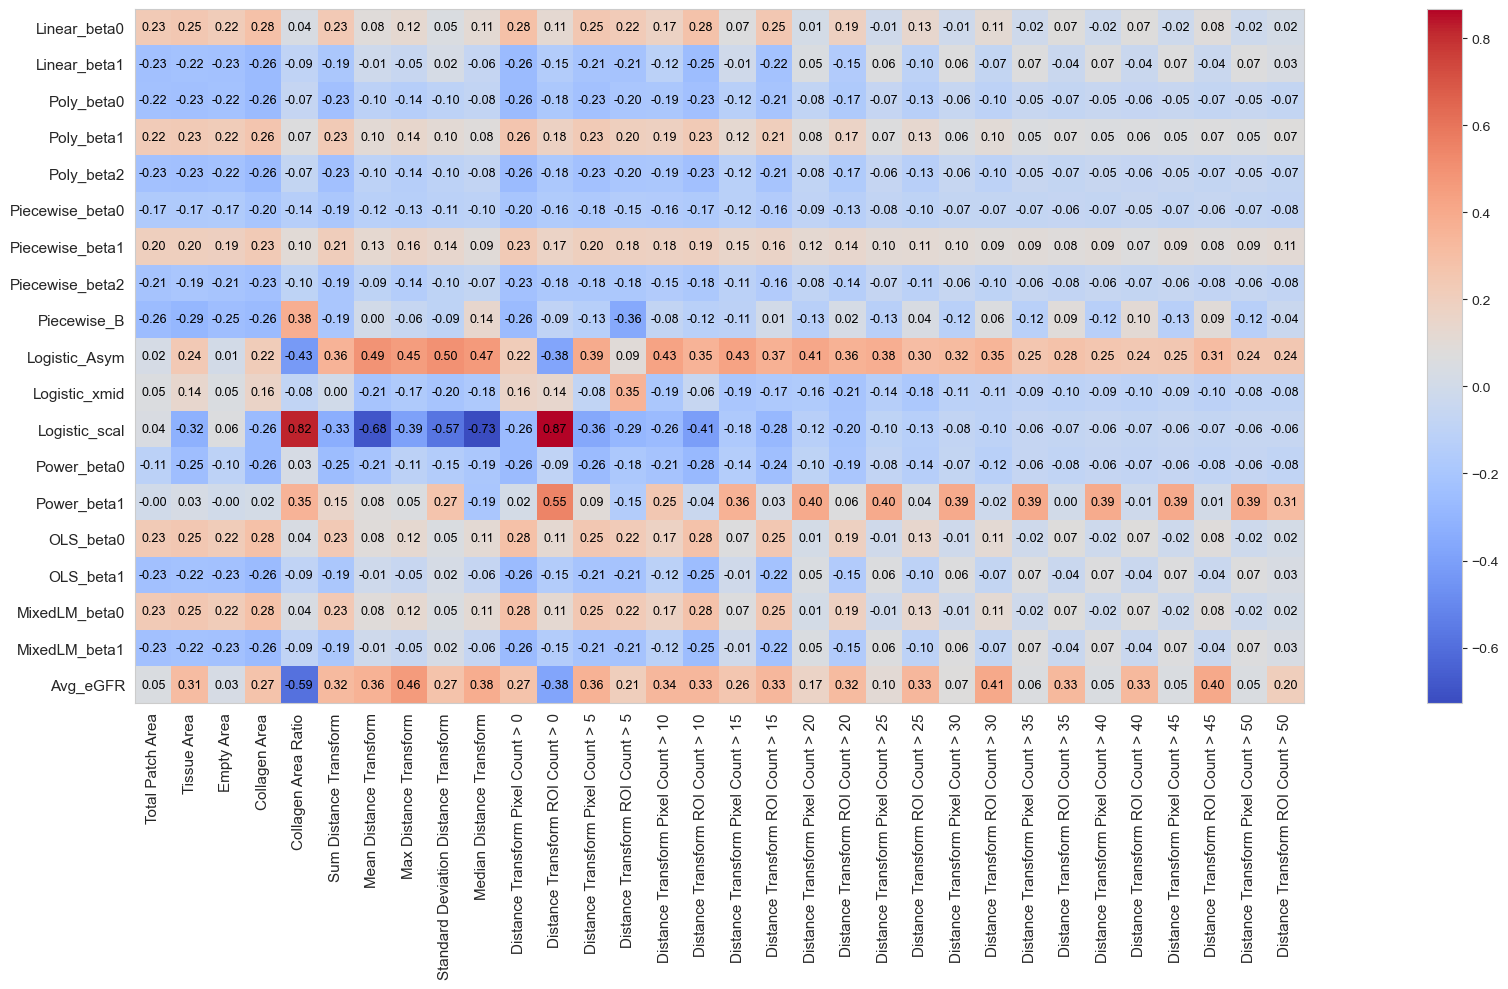

In [48]:
# Visualize the correlation matrix
plt.figure(figsize=(25, 10))  # Adjust width and height as needed

plt.imshow(filtered_corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add colorbar for visualization

# Customize xticks and yticks
plt.xticks(np.linspace(0, len(filtered_corr_matrix.columns)-1, len(filtered_corr_matrix.columns)),
           filtered_corr_matrix.columns, rotation=90, fontsize=11)
plt.yticks(np.arange(len(filtered_corr_matrix.index)), filtered_corr_matrix.index, fontsize=11)

# # Example usage with annotate
# plt.annotate('Label', xy=(-0.5, 0), xytext=(20, 20), xycoords='data', textcoords='offset points',
#              fontsize=10, ha='center', va='bottom',
#              bbox=dict(boxstyle='square', fc='white', color='k'),
#              arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=1.0', lw=1.5, color='k'))

# Loop over data dimensions and create text annotations (optional)
for i in range(len(filtered_corr_matrix.index)):
    for j in range(len(filtered_corr_matrix.columns)):
        plt.text(j, i, f'{filtered_corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()  # Ensure labels are not cut off
plt.grid(False)

plt.show()
